# Линейная регрессия

## 1. Поиск градиента

Продолжить формулу для взятия векторной производной по х для функции квадрата ошибки <br>(в красивом формате со всеми значками угловых скобок, операторов и т. д.). После выполнения этого вы вспомните формулу градиента для квадратичной ошибки и поймете как писать формулы на языке математической верстки TeX

$$ f(x) = ||Ax-y||^2 = (Ax-y)^T(Ax-y)$$
$$ D_f(x) =  \frac{d}{dx} (Ax - y)^T (Ax - y) $$
$$ \nabla f(x) = 2A^T (A x - y) $$

## 2. Прямое решение через ноль производной

После пункта 1 у вас есть формула для градиента квадратичной функции ошибки. Она измеряет уровень "неверности" решения (вектора $\vec{x}$). Теперь её надо приравнять к 0 и построить формулу, чтобы узнать при каком x это происходит.


## Используемые формулы при выводе градиента

Норма вектора через скалярное произведение:
$$ \|v\|^2 = \langle v, v \rangle $$
Дифференциал скалярного произведения одинаковых векторов:
$$ d\langle u, u \rangle = 2 \langle u, du \rangle $$   
Дифференциал линейной функции (так как \( y \) — константа):
$$ d(Ax - y) = Adx $$                  
Скалярное произведение как трансп. умножение:
$$ \langle u, v \rangle = u^T v $$
Свойство линейного отображения в скалярном произведении:  
$$ \langle u,\ A v \rangle = \langle A^T u,\ v \rangle $$
Градиент как линейное отображение:
$$ df(x) = \langle \nabla f(x), dx \rangle $$
$$ $$
$$ f(x) = \|Ax - y\|^2 = \langle Ax - y,\ Ax - y \rangle $$
$$ $$
$$ D_f(x) = d\langle Ax - y, Ax - y \rangle = 2\langle Ax - y,\ A dx \rangle = 2\langle A^T(Ax - y),\ dx \rangle$$
$$ $$
$$ \Rightarrow \nabla f(x) = 2A^T(Ax - y) $$

### 2.1 Реализация прямого решения

In [1]:
import numpy as np
import matplotlib.pyplot as plt

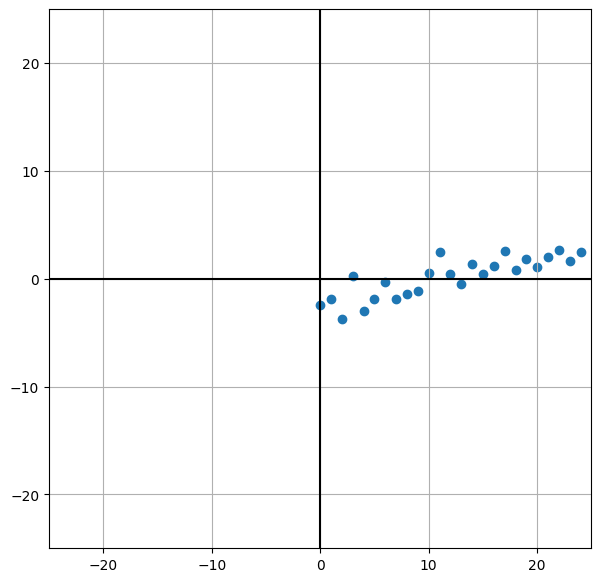

In [2]:
# ваши параметры по вариантам
a_orig = 0.2
b_orig = -2
random_state = 2 # х, где х - номер в списке группы, 2

# это тот самый столбец который мы и должны отыскать будем нашими методами.
# сейчас конечно мы его знаем наперед потому что нам надо создать данные
# но в жизни мы изначально этих чисел не знаем и в жизни задача в том чтобы их найти

x_orig = np.array([a_orig, b_orig])

np.random.seed(random_state)

A = np.stack([np.arange(0, 25), np.ones(25)]).T

# @ - операция матричного умножения в библиотеке NumPy
y = A @ x_orig + np.random.standard_normal(25)
# добавили нормально распределённого шума в данных
# этим система станет несовместна для обычного решения

f, ax = plt.subplots(figsize=(7, 7))

# A[:, 0] - выбрать первый столбец, A[0, :] - выбрать первую строку
plt.scatter(A[:, 0], y)

ax.set_xlim(-25, 25)
ax.set_ylim(-25, 25)
# рисуем координатные оси
ax.axvline(0, color="black")
ax.axhline(0, color="black")
ax.grid(True)

In [ ]:
A, y

### Вопрос - зачем был дописан вектор единиц справа к иксу?

Ответ: Добавление столбца единиц в матрицу (A) нужно, чтобы учесть свободный коэффициент (b) в уравнении. Это позволяет модели правильно предсказать значение, даже если (x = 0).

Так выглядит матрица с добавленным столбцом единиц:

$$
A = \begin{pmatrix}
x_1 & 1 \\
x_2 & 1 \\
\vdots & \vdots \\
x_n & 1
\end{pmatrix}
$$

Таким образом, модель учитывает не только зависимости от (x), но и добавляет фиксированное смещение (b).


In [3]:
# допишите код для поиска a и b через 0 производной и выведите какой вышел результат
#a_b_analytical = ...
#a_b_analytical

A_T_A = A.T @ A
A_T_y = A.T @ y
a_b_analytical = np.linalg.inv(A_T_A) @ A_T_y
print(f"Аналитические параметры: a = {a_b_analytical[0]}, b = {a_b_analytical[1]}")

Аналитические параметры: a = 0.21382214209220413, b = -2.4175406007755695


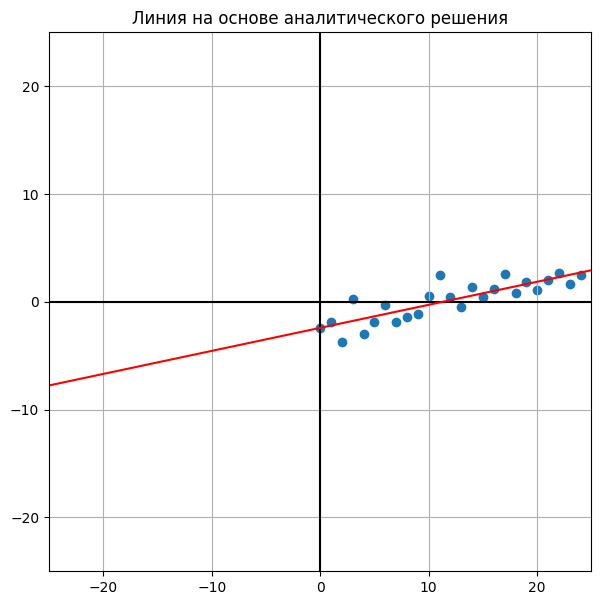

In [4]:
# постройте линию которая вышла рядом с изначальными данными


f, ax = plt.subplots(figsize=(7, 7))
plt.scatter(A[:, 0], y)
ax.set_xlim(-25, 25)
ax.set_ylim(-25, 25)
ax.axvline(0, color="black")
ax.axhline(0, color="black")
ax.grid(True)

# Линия, полученная с помощью аналитического решения
ax.plot([-25, 25], [a_b_analytical[0]*(-25) + a_b_analytical[1], a_b_analytical[0]*25 + a_b_analytical[1]], color="red")
ax.set_title('Линия на основе аналитического решения')
plt.show()

## 2. Решение с помощью градиентного спуска

С помощью найденных выше формул градиента, совершить шаги градиентного спуска для тех же данных.<br>
Подобрать значение $\alpha$, чтобы на графиках была видна сходимость за 10 шагов.<br> Начинаем с параметров 0, 0

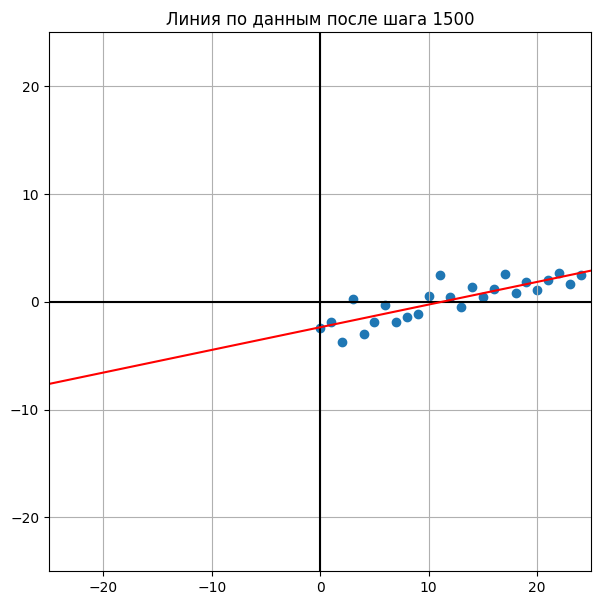

In [7]:
alpha = 0.00019  # шаг обучения
a_b_analytical = np.array([0.0, 0.0])

for i in range(1500):
    # предсказанные значения по текущим параметрам
    y_pred = A @ a_b_analytical

    # ошибка
    error = y_pred - y

    # градиент (формула: 2 * A.T @ (Ax - y))
    grad = 2 * (A.T @ error)

    # антиградиент — это минус градиент
    antigrad = -grad

    # делаем шаг градиентного спуска
    a_b_analytical += alpha * antigrad

f, ax = plt.subplots(figsize=(7, 7))
plt.scatter(A[:, 0], y)
ax.set_xlim(-25, 25)
ax.set_ylim(-25, 25)
ax.axvline(0, color='black')
ax.axhline(0, color='black')
ax.grid(True)

# линия которая обучилась
ax.plot(
    [-25, 25],
    [
        a_b_analytical[0] * (-25) + a_b_analytical[1],
        a_b_analytical[0] * (25) + a_b_analytical[1]
    ],
    color="red"
)
ax.set_title(f'Линия по данным после шага {i+1}')
plt.show()